# CS 7641 HW1 - Supervised Learning

This file will provide analysis for 5 different classification algorithms for two datasets.

Datasets: Default of Credit Card Clients, Bank Marketing.

Classification Algorithms: Decision Tree, Neural Network, Boosting, SVM, KNN.

There will be two outputs for each model: a plot of learning curve and a plot of model complexity. Both plots will be generated after hyperparameter tuning is performed.

# 1. Data Load and Preprocessing

First we load the data! Please save the datasets to your local machine and change the current directory to a file where you have the data stored.

In [82]:
import os
import pandas as pd
import numpy as np
import random

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')

#os.chdir(r"") #change this to your current working directory

### Load the Credit Card Data

In [83]:
## Read the datafile. It should be present in same directory as this IPYNB file

df_cc = pd.read_csv('CreditCardDefaultData.csv').astype('category')
print("Data has",len(df_cc),"rows and", len(df_cc.columns),"columns.")
if df_cc.isnull().values.any():
    print("Warning: Missing Data")
df_cc.head()
#df_cc.describe(include='all')

('Data has', 30000, 'rows and', 25, 'columns.')


,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
0,1,20000.0,2,2,1,24,2,2,-1,-1,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,2,120000.0,2,2,2,26,-1,2,0,0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,3,90000.0,2,2,2,34,0,0,0,0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,4,50000.0,2,2,1,37,0,0,0,0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,5,50000.0,1,2,1,57,-1,0,-1,0,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0


Now that the credit card data is loaded, we need to do some preprocessing. We have three categorical variables Sex, Education and Marriage. We will create dummy binary variables for each of these categorical variables using one-hot encoding. Also, we would remove the ID column from the dataset in order to avoid any noise from this variable during prediction.

In [84]:
col_1hot = ['SEX','EDUCATION','MARRIAGE']
df_1hot = df_cc[col_1hot]
df_1hot = pd.get_dummies(df_1hot)
df_others = df_cc.drop(col_1hot,axis=1)
df_cc = pd.concat([df_1hot,df_others],axis=1)
column_order = list(df_cc)
column_order.insert(0, column_order.pop(column_order.index('default.payment.next.month')))
df_cc = df_cc.loc[:, column_order]  #move the target variable to the front


numericcols = ['AGE','LIMIT_BAL','PAY_0','PAY_2','PAY_3','PAY_4','PAY_5','PAY_6','BILL_AMT1','BILL_AMT2','BILL_AMT3','BILL_AMT4','BILL_AMT5','BILL_AMT6','PAY_AMT1','PAY_AMT2','PAY_AMT3','PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']
df_num = df_cc[numericcols]
df_num = df_num.apply(pd.to_numeric) #Convert all columns to numeric, since it is read as categorical
df_cc_categorical = df_cc.drop(numericcols,axis=1)
df_cc = pd.concat([df_cc_categorical,df_num],axis=1)

df_cc.drop(['ID'], axis=1, inplace=True) #drop ID variable

df_cc.head()

,default.payment.next.month,SEX_1,SEX_2,EDUCATION_0,EDUCATION_1,EDUCATION_2,EDUCATION_3,EDUCATION_4,EDUCATION_5,EDUCATION_6,...,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
0,1,0,1,0,0,1,0,0,0,0,...,689.0,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0
1,1,0,1,0,0,1,0,0,0,0,...,2682.0,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0
2,0,0,1,0,0,1,0,0,0,0,...,13559.0,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0
3,0,0,1,0,0,1,0,0,0,0,...,49291.0,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0
4,0,1,0,0,0,1,0,0,0,0,...,35835.0,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0


We now have a file with no missing data in the format [y, X] where all features are binary {0,1}. The credit card data is ready to go! Now we move on to loading the Bank Marketing data.

### Load the Bank Marketing Data

In [86]:
## ## Read the datafile. It should be present in same directory as this IPYNB file

df_bank = pd.read_csv('BankMarketingData.csv')
print("Data has",len(df_bank),"rows and", len(df_bank.columns),"columns.")
if df_bank.isnull().values.any():
    print("Warning: Missing Data")
#df_bank.head()
#df_bank.describe(include='all')

('Data has', 45307, 'rows and', 21, 'columns.')


This dataset needs some preprocessing love too. We will convert all categorical columns using one hot encoding. Additionally, we will standardize all of the numeric features and we will convert the target variable from {no,yes} to {0,1}. It should be noted that the feature 'pdays' is numeric but contains values that are '999' if the customer was not called before. It may be worth while to create a new feature that defines whether or not {0,1} a customer had been called before. In the current state the '999' values may be outliers.

In [87]:
col_1hot = ['job','marital','education','default','housing','loan','contact','month','day_of_week','poutcome']
df_1hot = df_bank[col_1hot]
df_1hot = pd.get_dummies(df_1hot)
df_others = df_bank.drop(col_1hot,axis=1)
df_bank = pd.concat([df_others,df_1hot],axis=1)
column_order = list(df_bank)
column_order.insert(0, column_order.pop(column_order.index('y')))
df_bank = df_bank.loc[:, column_order]
df_bank['y'].replace("no",0,inplace=True)
df_bank['y'].replace("yes",1,inplace=True)
df_bank['y'] = df_bank['y'].astype('category')

numericcols = ['age','duration','campaign','pdays','previous','emp.var.rate','cons.price.idx','cons.conf.idx','euribor3m','nr.employed']
df_num = df_bank[numericcols]
df_bank_categorical = df_bank.drop(numericcols,axis=1)
df_bank = pd.concat([df_bank_categorical,df_num],axis=1)

df_bank.drop(['pdays'], axis=1, inplace=True) #Drop pdays variable because it is highly correlated to our response variable
#df_bank.head()

Now we have successfully loaded and processed both datasets. We are ready to start the ML!

# 2. Helper Functions

### Data Loading and Function Prep

Before we get into the algorithms, let's define some helper functions that will be used across all of the models and both datasets. We will define a function to load the data (not really necessary in a Jupyter notebook, but good if this is exported as a .py for later use). We will also define a function that plots the learning curve (training and cross validation score as a function of training examples) of an estimator (classification model). Finally, we define functions to output final model scores using an untouched test dataset.

In [88]:
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_validate, train_test_split, GridSearchCV
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
import itertools
import timeit

plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 12
plt.rcParams['font.size'] = 12

def import_data():

    X1 = np.array(df_cc.values[:,1:-1],dtype='int64')
    Y1 = np.array(df_cc.values[:,0],dtype='int64')
    X2 = np.array(df_bank.values[:,1:-1],dtype='int64')
    Y2 = np.array(df_bank.values[:,0],dtype='int64')
    return X1, Y1, X2, Y2


def plot_learning_curve(clf, X, y, title="Insert Title"):
    
    n = len(y)
    train_mean = []; train_std = [] #model performance score (f1)
    cv_mean = []; cv_std = [] #model performance score (f1)
    fit_mean = []; fit_std = [] #model fit/training time
    pred_mean = []; pred_std = [] #model test/prediction times
    train_sizes=(np.linspace(.05, 1.0, 20)*n).astype('int')  
    
    for i in train_sizes:
        idx = np.random.randint(X.shape[0], size=i)
        X_subset = X[idx,:]
        y_subset = y[idx]
        scores = cross_validate(clf, X_subset, y_subset, cv=3, scoring='f1', n_jobs=-1, return_train_score=True)
        
        train_mean.append(np.mean(scores['train_score'])); train_std.append(np.std(scores['train_score']))
        cv_mean.append(np.mean(scores['test_score'])); cv_std.append(np.std(scores['test_score']))
        fit_mean.append(np.mean(scores['fit_time'])); fit_std.append(np.std(scores['fit_time']))
        pred_mean.append(np.mean(scores['score_time'])); pred_std.append(np.std(scores['score_time']))
    
    train_mean = np.array(train_mean); train_std = np.array(train_std)
    cv_mean = np.array(cv_mean); cv_std = np.array(cv_std)
    fit_mean = np.array(fit_mean); fit_std = np.array(fit_std)
    pred_mean = np.array(pred_mean); pred_std = np.array(pred_std)
    
    plot_LC(train_sizes, train_mean, train_std, cv_mean, cv_std, title)
    plot_times(train_sizes, fit_mean, fit_std, pred_mean, pred_std, title)
    
    return train_sizes, train_mean, fit_mean, pred_mean
    

def plot_LC(train_sizes, train_mean, train_std, cv_mean, cv_std, title):
    
    plt.figure()
    plt.title("Learning Curve: "+ title)
    plt.xlabel("Training Examples")
    plt.ylabel("Model F1 Score")
    plt.fill_between(train_sizes, train_mean - 2*train_std, train_mean + 2*train_std, alpha=0.1, color="b")
    plt.fill_between(train_sizes, cv_mean - 2*cv_std, cv_mean + 2*cv_std, alpha=0.1, color="r")
    plt.plot(train_sizes, train_mean, 'o-', color="b", label="Training Score")
    plt.plot(train_sizes, cv_mean, 'o-', color="r", label="Cross-Validation Score")
    plt.legend(loc="best")
    plt.show()
    
    
def plot_times(train_sizes, fit_mean, fit_std, pred_mean, pred_std, title):
    
    plt.figure()
    plt.title("Modeling Time: "+ title)
    plt.xlabel("Training Examples")
    plt.ylabel("Training Time (s)")
    plt.fill_between(train_sizes, fit_mean - 2*fit_std, fit_mean + 2*fit_std, alpha=0.1, color="b")
    plt.fill_between(train_sizes, pred_mean - 2*pred_std, pred_mean + 2*pred_std, alpha=0.1, color="r")
    plt.plot(train_sizes, fit_mean, 'o-', color="b", label="Training Time (s)")
    plt.plot(train_sizes, pred_std, 'o-', color="r", label="Prediction Time (s)")
    plt.legend(loc="best")
    plt.show()
    
    
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion Matrix', cmap=plt.cm.Blues):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(2), range(2)):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    
    
def final_classifier_evaluation(clf,X_train, X_test, y_train, y_test):
    
    start_time = timeit.default_timer()
    clf.fit(X_train, y_train)
    end_time = timeit.default_timer()
    training_time = end_time - start_time
    
    start_time = timeit.default_timer()    
    y_pred = clf.predict(X_test)
    end_time = timeit.default_timer()
    pred_time = end_time - start_time
    
    y_train_pred = clf.predict(X_train)
    auc_train = roc_auc_score(y_train, y_train_pred)
    f1_train = f1_score(y_train, y_train_pred)
    accuracy_train = accuracy_score(y_train, y_train_pred)
    precision_train = precision_score(y_train, y_train_pred)
    recall_train = recall_score(y_train, y_train_pred)
    cm_train = confusion_matrix(y_train, y_train_pred)
    
    auc = roc_auc_score(y_test, y_pred)
    f1 = f1_score(y_test,y_pred)
    accuracy = accuracy_score(y_test,y_pred)
    precision = precision_score(y_test,y_pred)
    recall = recall_score(y_test,y_pred)
    cm = confusion_matrix(y_test,y_pred)

    print("Model Evaluation Metrics Using Train Dataset")
    print("*****************************************************")
    print("Model Training Time (s):   "+"{:.5f}".format(training_time))
    print("F1 Score:  "+"{:.2f}".format(f1_train))
    print("Accuracy:  "+"{:.2f}".format(accuracy_train)+"     AUC:       "+"{:.2f}".format(auc_train))
    print("Precision: "+"{:.2f}".format(precision_train)+"     Recall:    "+"{:.2f}".format(recall_train))
    
    print("Model Evaluation Metrics Using Untouched Test Dataset")
    print("*****************************************************")
    print("Model Prediction Time (s): "+"{:.5f}\n".format(pred_time))
    print("F1 Score:  "+"{:.2f}".format(f1))
    print("Accuracy:  "+"{:.2f}".format(accuracy)+"     AUC:       "+"{:.2f}".format(auc))
    print("Precision: "+"{:.2f}".format(precision)+"     Recall:    "+"{:.2f}".format(recall))
    print("*****************************************************")
    plt.figure()
    plot_confusion_matrix(cm, classes=["0","1"], title='Confusion Matrix')
    plt.show()

# 3. The Fun Part: Machine Learning!

# Neural Network Classifier

This section will build a forward-feed neural network which computes weights via backpropagation (a multilayer perceptron). The main hyperparameter will be number of hidden nodes in a network defined by a single hidden layer, while others that could be searched over in grid search are activation function, and learning rate.

In [93]:
from sklearn.neural_network import MLPClassifier

#Activation Function
def hyperNN(X_train, y_train, X_test, y_test, title):

    f1_test = []
    f1_train = []
    train_time = []
    hlist = ['tanh','relu','logistic','identity']
    for i in hlist:         
            clf = MLPClassifier(hidden_layer_sizes=(10,), solver='adam', activation=i, 
                                learning_rate_init=1e-4, random_state=100)
            
            start_time = timeit.default_timer()
            clf.fit(X_train, y_train)
            end_time = timeit.default_timer()
            training_time = end_time - start_time
            
            #clf.fit(X_train, y_train)
            y_pred_test = clf.predict(X_test)
            y_pred_train = clf.predict(X_train)
            f1_test.append(f1_score(y_test, y_pred_test))
            f1_train.append(f1_score(y_train, y_pred_train))
            train_time.append(training_time)
      
    fig, ax1 = plt.subplots()
    ax2 = ax1.twinx()
    
    ax1.plot(hlist, f1_test, color='r', label='Validation F1 Score')
    ax1.plot(hlist, f1_train, color = 'b', label='Train F1 Score')
    ax2.plot(hlist, train_time, color = 'g', label='Train Time')
    ax1.set_ylabel('Model F1 Score')
    ax2.set_ylabel('Train Time')
    plt.xlabel('Activation Function')
    
    plt.title(title)
    ax1.legend(loc=3)
    ax2.legend(loc=1)
    plt.tight_layout()
    plt.show()

#Number of Layers
def hyperNN2(X_train, y_train, X_test, y_test, title):

    f1_test = []
    f1_train = []
    hlist = range(1,10,1)
    for layer in hlist:
        layers = []
        for neuron in range(layer):
            layers.append(10)
        clf = MLPClassifier(hidden_layer_sizes=(layers), solver='adam', activation='relu', 
                            learning_rate_init=1e-4, random_state=100)
        clf.fit(X_train, y_train)
        y_pred_test = clf.predict(X_test)
        y_pred_train = clf.predict(X_train)
        f1_test.append(f1_score(y_test, y_pred_test))
        f1_train.append(f1_score(y_train, y_pred_train))
      
    plt.plot(hlist, f1_test, 'o-', color='r', label='Validation F1 Score')
    plt.plot(hlist, f1_train, 'o-', color = 'b', label='Train F1 Score')
    plt.ylabel('Model F1 Score')
    plt.xlabel('No. of Layers')
    
    plt.title(title)
    plt.legend(loc='best')
    plt.tight_layout()
    plt.show()

#Number of Neurons per layer
def hyperNN3(X_train, y_train, X_test, y_test, title):

    f1_test = []
    f1_train = []
    #hlist = np.linspace(1,150,30).astype('int')
    #hlist = [(4,2,1),(4,4,4),(8,4,2),(8,8,8),(16,8,4), (16,16,16),(32,16,8), (32,32,32), (64,32,16), (64,64,64) ]
    hlist = [(2,2,2,2),(4,4,2,2),(8,4,2,2),(8,8,4,4),(16,8,4,2), (16,8,8,4),(32,16,8,4),(32,16,16,8),(64,32,16,8),(64,32,32,16)]
    #hlist = [(4,4,2,2,2),(8,4,4,2,2),(8,8,4,4,2), (16,8,8,4,4),(16,16,8,8,4),(32,16,8,4,2),(32,16,16,8,8),(64,32,16,8,4)]
    
    #hlist = [(4,2), (8,4), (8,8),(16,8), (16,16), (32,16), (32,32),(64,32), (64,64), (128,64), (128,128) ]
    #hlist = [(5,3,2)]
    #llist = ['(4,2,1)','(4,4,4)','(8,4,2)','(8,8,8)','(16,8,4)','(16,16,16)','(32,16,8)', '(32,32,32)' ,'(64,32,16)', '(64,64,64)']
    #llist = ['(4,2)','(8,4)','(8,8)','(16,8)', '(16,16)' ,'(32,16)', '(32,32)','(64,32)','(64,64)','(128,64)','(128,128)']
    llist = ['(2,2,2,2)','(4,4,2,2)','(8,4,2,2)', '(8,8,4,4)' ,'(16,8,4,2)', '(16,8,8,4)','(32,16,8,4)','(32,16,16,8)','(64,32,16,8)','(64,32,32,16)']
    #llist = ['(4,4,2,2,2)','(8,4,4,2,2)','(8,8,4,4,2)','(16,8,8,4,4)', '(16,16,8,8,4)','(32,16,8,4,2)','(32,16,16,8,8)','(64,32,16,8,4)']
    
    for i in hlist:
        clf = MLPClassifier(hidden_layer_sizes=i, solver='adam', activation='tanh', 
                            learning_rate_init=1e-4, random_state=100)
        clf.fit(X_train, y_train)
        y_pred_test = clf.predict(X_test)
        y_pred_train = clf.predict(X_train)
        f1_test.append(f1_score(y_test, y_pred_test))
        f1_train.append(f1_score(y_train, y_pred_train))

    from matplotlib.pyplot import figure
    figure(num=None, figsize=(12, 5), dpi=80, facecolor='w', edgecolor='k')
    plt.plot(llist, f1_test, 'o-', color='r', label='Validation F1 Score')
    plt.plot(llist, f1_train, 'o-', color = 'b', label='Train F1 Score')
    plt.ylabel('Model F1 Score')
    plt.xlabel('No. Hidden Units')
    
    plt.title(title)
    plt.legend(loc='best')
    plt.tight_layout()
    plt.show()

#Learning Rate
def hyperNN4(X_train, y_train, X_test, y_test, title):

    f1_test = []
    f1_train = []
    hlist = [1e-6,1e-5,1e-4,1e-3,1e-2]
    llist = ['1e-6','1e-5','1e-4','1e-3','1e-2']

    for i in hlist:
        #clf = MLPClassifier(hidden_layer_sizes=(16,16,16), solver='adam', activation='tanh', 
        #                    learning_rate_init=i, random_state=100)
        clf = MLPClassifier(hidden_layer_sizes=(2,2,2,2), solver='adam', activation='tanh', 
                            learning_rate_init=i, random_state=100)
        
        clf.fit(X_train, y_train)
        y_pred_test = clf.predict(X_test)
        y_pred_train = clf.predict(X_train)
        f1_test.append(f1_score(y_test, y_pred_test))
        f1_train.append(f1_score(y_train, y_pred_train))

    from matplotlib.pyplot import figure
    figure(num=None, figsize=(12, 5), dpi=80, facecolor='w', edgecolor='k')
    plt.plot(llist, f1_test, 'o-', color='r', label='Validation F1 Score')
    plt.plot(llist, f1_train, 'o-', color = 'b', label='Train F1 Score')
    plt.ylabel('Model F1 Score')
    plt.xlabel('Learning Rate')
    
    plt.title(title)
    plt.legend(loc='best')
    plt.tight_layout()
    plt.show()
    
    
# def NNGridSearchCV(X_train, y_train):
#     #parameters to search:
#     #number of hidden units
#     #learning_rate
#     h_units = [(10,10,5,5,3,3),(5,5,5,5,5,5),(5,3), (10,5), (40,20), 5, 20, 40]
#     learning_rates = [1e-1,1e-3,1e-6]
#     param_grid = {'hidden_layer_sizes': h_units, 'learning_rate_init': learning_rates}

#     net = GridSearchCV(estimator = MLPClassifier(solver='adam',activation='relu',random_state=100),
#                        param_grid=param_grid, cv=10)
#     net.fit(X_train, y_train)
#     print("Per Hyperparameter tuning, best parameters are:")
#     print(net.best_params_)
#     return net.best_params_['hidden_layer_sizes'], net.best_params_['learning_rate_init']

In [94]:
#Break Credit Card Dataset into train, validation and test

ccX,ccY,bankX,bankY = import_data()
X_train_val, X_test, y_train_val, y_test = train_test_split(np.array(ccX),np.array(ccY), test_size=0.20, random_state =3)
scaler = StandardScaler().fit(X_train_val)
X_train_val_scaled = scaler.transform(X_train_val)
X_test_scaled = scaler.transform(X_test)
X_train, X_val, y_train, y_val = train_test_split(X_train_val_scaled,y_train_val, test_size=0.25, random_state = 3)

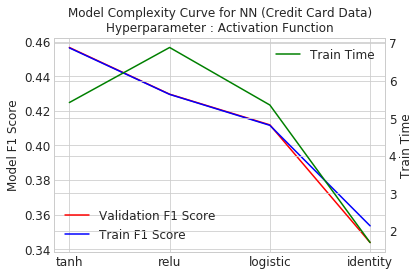

In [66]:
#Find Activation Function
hyperNN(X_train, y_train, X_val, y_val,title="Model Complexity Curve for NN (Credit Card Data)\nHyperparameter : Activation Function")

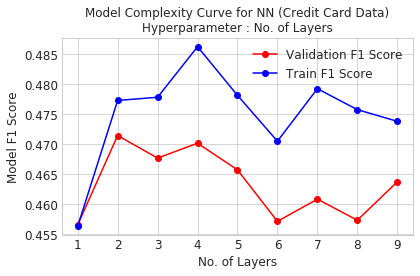

In [67]:
#Number of Layers
hyperNN2(X_train, y_train, X_val, y_val,title="Model Complexity Curve for NN (Credit Card Data)\nHyperparameter : No. of Layers")

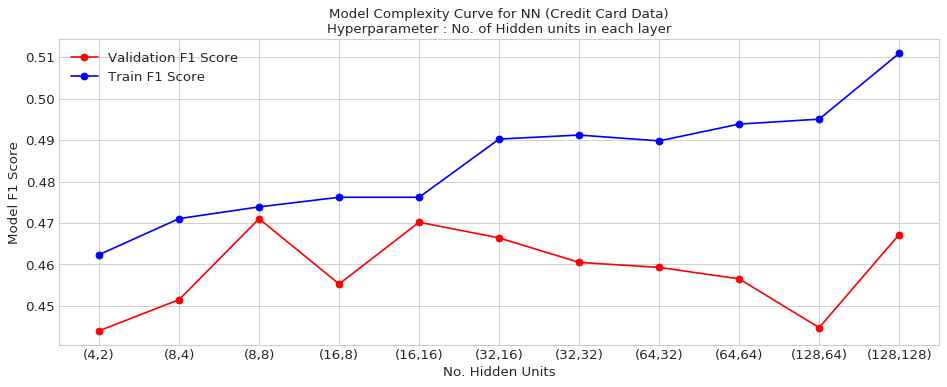

In [70]:
#Number of neurons in each layer
hyperNN3(X_train, y_train, X_val, y_val,title="Model Complexity Curve for NN (Credit Card Data)\nHyperparameter : No. of Hidden units in each layer")

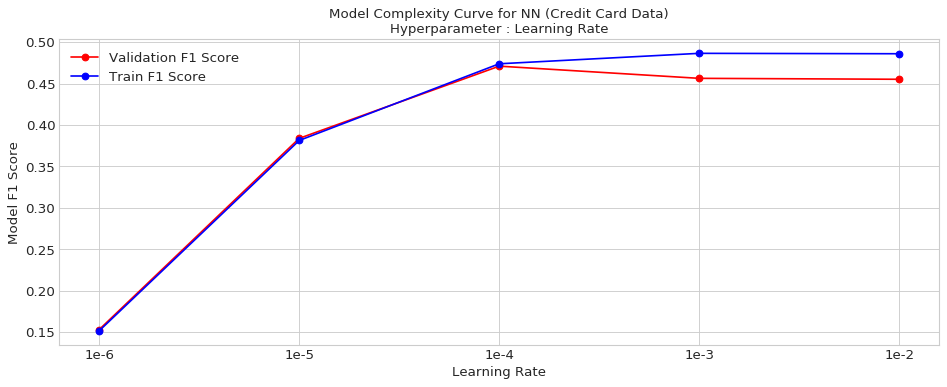

In [72]:
#Learning Rate
hyperNN4(X_train, y_train, X_val, y_val,title="Model Complexity Curve for NN (Credit Card Data)\nHyperparameter : Learning Rate")

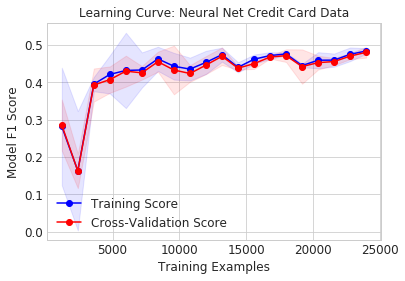

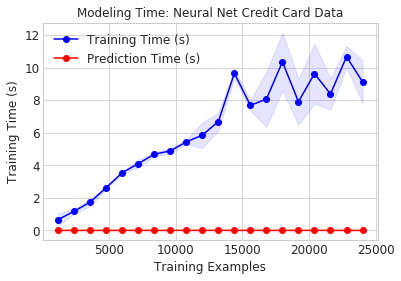

In [12]:
#Plot Learning Curves
estimator_cc = MLPClassifier(hidden_layer_sizes=(8,8), solver='adam', activation='tanh', 
                               learning_rate_init=1e-4, random_state=100)
train_samp_cc, NN_train_score_cc, NN_fit_time_cc, NN_pred_time_cc = plot_learning_curve(estimator_cc, X_train_val_scaled, y_train_val,title="Neural Net Credit Card Data")

Model Evaluation Metrics Using Train Dataset
*****************************************************
Model Training Time (s):   7.55154
F1 Score:  0.47
Accuracy:  0.82     AUC:       0.66
Precision: 0.67     Recall:    0.37
Model Evaluation Metrics Using Untouched Test Dataset
*****************************************************
Model Prediction Time (s): 0.00616

F1 Score:  0.48
Accuracy:  0.83     AUC:       0.66
Precision: 0.67     Recall:    0.38
*****************************************************


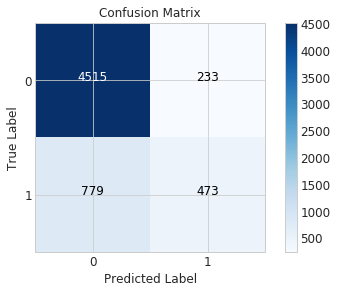

In [75]:
#Get Evaluation Statistics
final_classifier_evaluation(estimator_cc, X_train_val_scaled, X_test_scaled, y_train_val, y_test)

In [97]:
#Break Bank Marketing Dataset in train, validation and test
X_train_val, X_test, y_train_val, y_test = train_test_split(np.array(bankX),np.array(bankY), test_size=0.20, random_state = 33)
scaler = StandardScaler().fit(X_train_val)
X_train_val_scaled = scaler.transform(X_train_val)
X_test_scaled = scaler.transform(X_test)
X_train, X_val, y_train, y_val = train_test_split(X_train_val_scaled,y_train_val, test_size=0.25, random_state = 33)

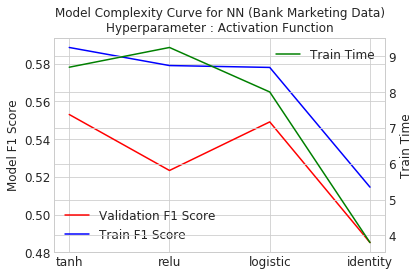

In [18]:
#Activation Function
hyperNN(X_train, y_train, X_val, y_val,title="Model Complexity Curve for NN (Bank Marketing Data)\nHyperparameter : Activation Function")

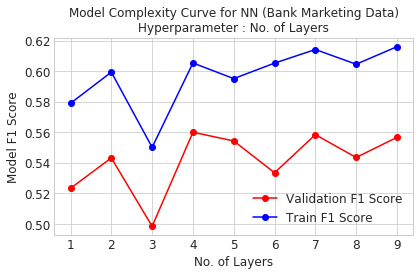

In [19]:
#Number of Layers
hyperNN2(X_train, y_train, X_val, y_val,title="Model Complexity Curve for NN (Bank Marketing Data)\nHyperparameter : No. of Layers")

/home/ravi/miniconda2/lib/python2.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


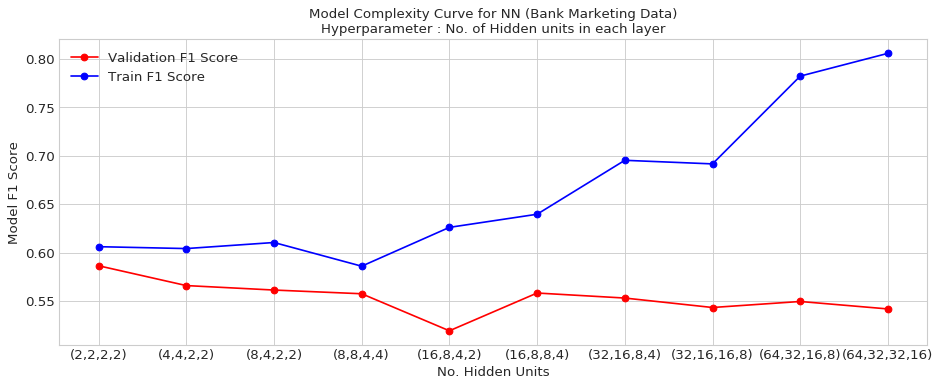

In [21]:
#Number of Neurons per Layer
hyperNN3(X_train, y_train, X_val, y_val,title="Model Complexity Curve for NN (Bank Marketing Data)\nHyperparameter : No. of Hidden units in each layer")

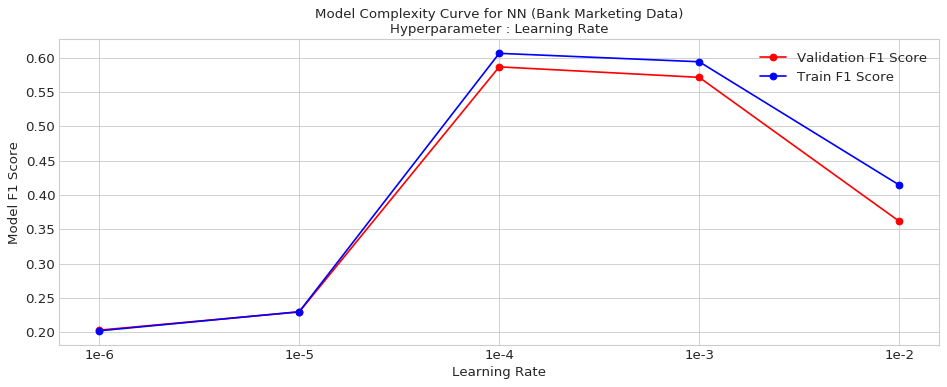

In [23]:
#Learning Rate
hyperNN4(X_train, y_train, X_val, y_val,title="Model Complexity Curve for NN (Bank Marketing Data)\nHyperparameter : Learning Rate")

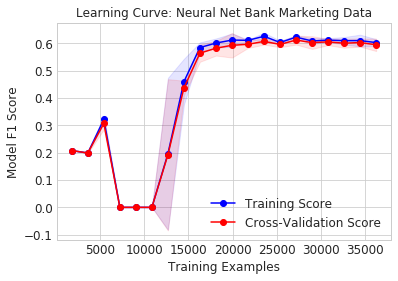

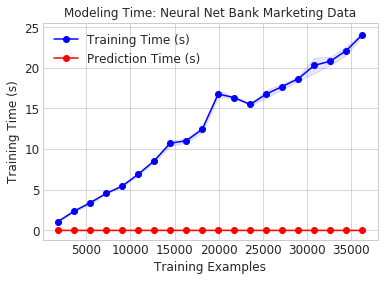

In [15]:
#Plot Learning Curves
estimator_bank = MLPClassifier(hidden_layer_sizes=(2,2,2,2), solver='adam', activation='tanh', 
                               learning_rate_init=1e-4, random_state=100)
train_samp_bank, NN_train_score_bank, NN_fit_time_bank, NN_pred_time_bank = plot_learning_curve(estimator_bank, X_train_val_scaled, y_train_val,title="Neural Net Bank Marketing Data")

Model Evaluation Metrics Using Train Dataset
*****************************************************
Model Training Time (s):   22.07539
F1 Score:  0.60
Accuracy:  0.91     AUC:       0.77
Precision: 0.61     Recall:    0.60
Model Evaluation Metrics Using Untouched Test Dataset
*****************************************************
Model Prediction Time (s): 0.00921

F1 Score:  0.60
Accuracy:  0.91     AUC:       0.77
Precision: 0.62     Recall:    0.59
*****************************************************


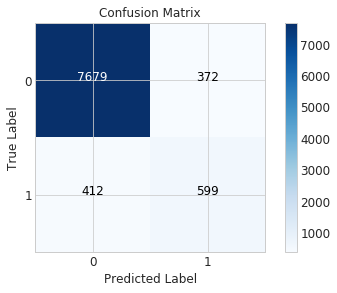

In [26]:
#Get Model Evaluation Statistics
final_classifier_evaluation(estimator_bank, X_train_val_scaled, X_test_scaled, y_train_val, y_test)

The final section for neural network will plot the loss curve for each dataset over the iterations.

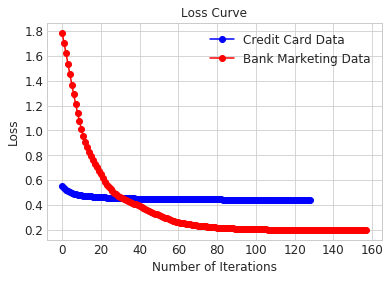

In [27]:
ccX,ccY,bankX,bankY = import_data()



X_train_val, X_test, y_train_val, y_test = train_test_split(np.array(ccX),np.array(ccY), test_size=0.20, random_state =3)
scaler = StandardScaler().fit(X_train_val)
X_train_val_scaled = scaler.transform(X_train_val)
X_test_scaled = scaler.transform(X_test)
estimator_cc = MLPClassifier(hidden_layer_sizes=(8,8), solver='adam', activation='tanh', 
                               learning_rate_init=1e-4, random_state=100)
estimator_cc.fit(X_train_val_scaled, y_train_val)
a = estimator_cc.loss_curve_


X_train_val, X_test, y_train_val, y_test = train_test_split(np.array(bankX),np.array(bankY), test_size=0.20, random_state =33)
scaler = StandardScaler().fit(X_train_val)
X_train_val_scaled = scaler.transform(X_train_val)
X_test_scaled = scaler.transform(X_test)
estimator_bank = MLPClassifier(hidden_layer_sizes=(2,2,2,2), solver='adam', activation='tanh', 
                               learning_rate_init=1e-4, random_state=100)

estimator_bank.fit(X_train_val_scaled, y_train_val)
b = estimator_bank.loss_curve_

plt.figure()
plt.title("Loss Curve")
plt.xlabel("Number of Iterations")
plt.ylabel("Loss")
plt.plot(a, 'o-', color="b", label="Credit Card Data")
plt.plot(b, 'o-', color="r", label="Bank Marketing Data")
plt.legend(loc="best")
plt.show()

# Support Vector Machine Classifier

This section will build a support vector machine classifier. The primary hyperparameter will be kernel function: linear, polynomial, rbf (radial basis function), and sigmoid. We will also explore the penalty term 'C' and the kernel coefficient 'gamma'.

In [99]:
from sklearn.svm import SVC

def hyperSVM(X_train, y_train, X_test, y_test, title):

    f1_test = []
    f1_train = []
    kernel_func = ['linear','poly','rbf','sigmoid']
    for i in kernel_func:         
            if i == 'poly':
                for j in [2,3,4,5,6,7,8]:
                    clf = SVC(kernel=i, degree=j,random_state=100)
                    clf.fit(X_train, y_train)
                    y_pred_test = clf.predict(X_test)
                    y_pred_train = clf.predict(X_train)
                    f1_test.append(f1_score(y_test, y_pred_test))
                    f1_train.append(f1_score(y_train, y_pred_train))
            else:    
                clf = SVC(kernel=i, random_state=100)
                clf.fit(X_train, y_train)
                y_pred_test = clf.predict(X_test)
                y_pred_train = clf.predict(X_train)
                f1_test.append(f1_score(y_test, y_pred_test))
                f1_train.append(f1_score(y_train, y_pred_train))
                
    xvals = ['linear','poly2','poly3','poly4','poly5','poly6','poly7','poly8','rbf','sigmoid']
    plt.plot(xvals, f1_test, 'o-', color='r', label='Validation F1 Score')
    plt.plot(xvals, f1_train, 'o-', color = 'b', label='Train F1 Score')
    plt.ylabel('Model F1 Score')
    plt.xlabel('Kernel Function')
    
    plt.title(title)
    plt.legend(loc='best')
    plt.tight_layout()
    plt.show()
    
def SVMGridSearchCV(X_train, y_train):
    #parameters to search:
    #penalty parameter, C
    #
    #Cs = [0.5,1,4,16,32,64]
    #gammas = [1e-5,1e-3,1e-1,1e3,1e5]
    
    Cs = [1e-4, 1e-2, 1e0, 1e2, 1e4]
    gammas = [1e-4, 1e-2, 1e0, 1e2, 1e4]
    param_grid = {'C': Cs, 'gamma': gammas}

    clf = GridSearchCV(estimator = SVC(kernel='rbf',random_state=100),
                       param_grid=param_grid, cv=3)
    clf.fit(X_train, y_train)
    print("Per Hyperparameter tuning, best parameters are:")
    print(clf.best_params_)
    return clf.best_params_['C'], clf.best_params_['gamma']

In [100]:
#Break Credit Card Data in train, validation and test
ccX,ccY,bankX,bankY = import_data()
X_train_val, X_test, y_train_val, y_test = train_test_split(np.array(ccX),np.array(ccY), test_size=0.20, random_state = 3)
scaler = StandardScaler().fit(X_train_val)
X_train_val_scaled = scaler.transform(X_train_val)
X_test_scaled = scaler.transform(X_test)
X_train, X_val, y_train, y_val = train_test_split(X_train_val_scaled,y_train_val, test_size=0.25, random_state = 3)

/home/ravi/miniconda2/lib/python2.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


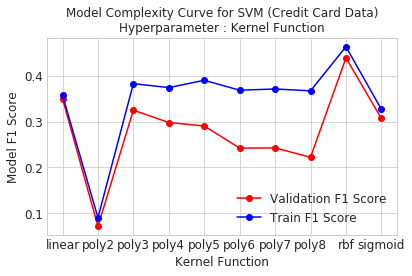

In [30]:
#Choice of Kernel
hyperSVM(X_train, y_train, X_val, y_val,title="Model Complexity Curve for SVM (Credit Card Data)\nHyperparameter : Kernel Function")

In [43]:
#Grid search to find optimal value of C and Gamma
C_val, gamma_val = SVMGridSearchCV(X_train_val_scaled, y_train_val)

Per Hyperparameter tuning, best parameters are:
{'C': 32, 'gamma': 0.001}


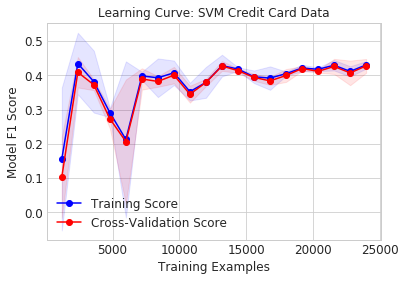

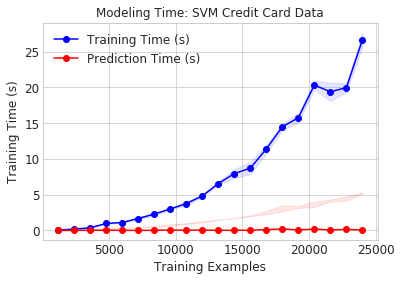

In [19]:
#Plot Learning Curve
estimator_cc = SVC(C=C_val, gamma=gamma_val, kernel='rbf', random_state=100)
train_samp_cc, SVM_train_score_cc, SVM_fit_time_cc, SVM_pred_time_cc = plot_learning_curve(estimator_cc, X_train_val_scaled, y_train_val,title="SVM Credit Card Data")

Model Evaluation Metrics Using Train Dataset
*****************************************************
Model Training Time (s):   39.31730
F1 Score:  0.43
Accuracy:  0.81     AUC:       0.64
Precision: 0.69     Recall:    0.31
Model Evaluation Metrics Using Untouched Test Dataset
*****************************************************
Model Prediction Time (s): 3.41286

F1 Score:  0.43
Accuracy:  0.83     AUC:       0.64
Precision: 0.68     Recall:    0.32
*****************************************************


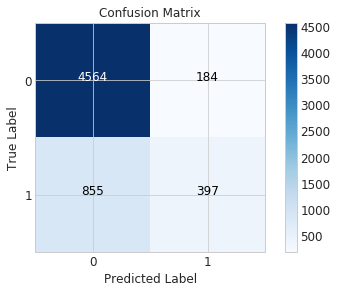

In [20]:
#Get Model Evaluation Statistics
final_classifier_evaluation(estimator_cc, X_train_val_scaled, X_test_scaled, y_train_val, y_test)

In [103]:
#Break Bank Marketing Data in train, validation and test
X_train_val, X_test, y_train_val, y_test = train_test_split(np.array(bankX),np.array(bankY), test_size=0.20, random_state = 33)
scaler = StandardScaler().fit(X_train_val)
X_train_val_scaled = scaler.transform(X_train_val)
X_test_scaled = scaler.transform(X_test)
X_train, X_val, y_train, y_val = train_test_split(X_train_val_scaled,y_train_val, test_size=0.25, random_state = 33)

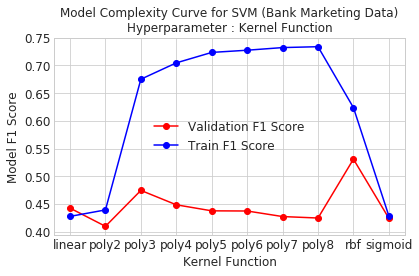

In [46]:
#Choose appropriate Kernel
hyperSVM(X_train, y_train, X_val, y_val,title="Model Complexity Curve for SVM (Bank Marketing Data)\nHyperparameter : Kernel Function")

In [44]:
#Grid Search to find best of hyperparameters
C_val, gamma_val = SVMGridSearchCV(X_train_val_scaled, y_train_val)

Per Hyperparameter tuning, best parameters are:
{'C': 10000.0, 'gamma': 0.0001}


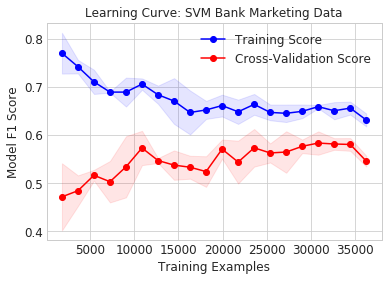

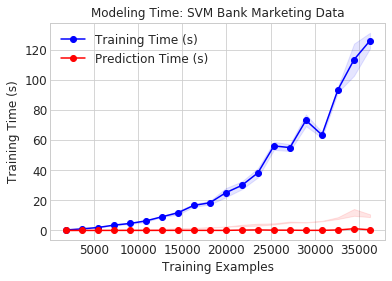

In [22]:
#Plot Learning Curves
estimator_bank = SVC(C=C_val, gamma=gamma_val, kernel='rbf', random_state=100)
train_samp_bank, SVM_train_score_bank, SVM_fit_time_bank, SVM_pred_time_bank = plot_learning_curve(estimator_bank, X_train_val_scaled, y_train_val,title="SVM Bank Marketing Data")

Model Evaluation Metrics Using Train Dataset
*****************************************************
Model Training Time (s):   348.53473
F1 Score:  0.60
Accuracy:  0.92     AUC:       0.74
Precision: 0.74     Recall:    0.50
Model Evaluation Metrics Using Untouched Test Dataset
*****************************************************
Model Prediction Time (s): 8.52250

F1 Score:  0.51
Accuracy:  0.91     AUC:       0.70
Precision: 0.64     Recall:    0.42
*****************************************************


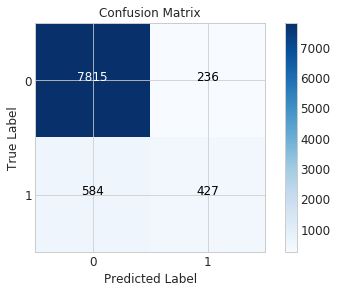

In [45]:
#Get Model Evaluation Statistics
final_classifier_evaluation(estimator_bank, X_train_val_scaled, X_test_scaled, y_train_val, y_test)

# KNN Classifier

This section will build a classifier using K-nearest neighbors. The hyperparameter will be n_neighbors and the distance metric. The Model Complexity curve will show F1 score as a function of number of neighbors.

In [66]:
from sklearn.neighbors import KNeighborsClassifier as kNN

#Number of nearest neighbors
def hyperKNN(X_train, y_train, X_test, y_test, title):
    
    f1_test = []
    f1_train = []
    klist = np.linspace(1,250,25).astype('int')
    #klist = range(1,40,2)
    for i in klist:
        clf = kNN(n_neighbors=i,n_jobs=-1)
        clf.fit(X_train,y_train)
        y_pred_test = clf.predict(X_test)
        y_pred_train = clf.predict(X_train)
        f1_test.append(f1_score(y_test, y_pred_test))
        f1_train.append(f1_score(y_train, y_pred_train))
        
    plt.plot(klist, f1_test, 'o-', color='r', label='Validation F1 Score')
    plt.plot(klist, f1_train, 'o-', color = 'b', label='Train F1 Score')
    plt.ylabel('Model F1 Score')
    plt.xlabel('No. Neighbors')
    
    plt.title(title)
    plt.legend(loc='best')
    plt.tight_layout()
    plt.show()

#Distance Metric    
def hyperKNN2(X_train, y_train, X_test, y_test, title):
    
    f1_test = []
    f1_train = []
    dmetric = ['manhattan','euclidean','chebyshev']
    #klist = range(1,40,2)
    for i in dmetric:
        clf = kNN(n_neighbors=33,metric = i,n_jobs=-1)
        clf.fit(X_train,y_train)
        y_pred_test = clf.predict(X_test)
        y_pred_train = clf.predict(X_train)
        f1_test.append(f1_score(y_test, y_pred_test))
        f1_train.append(f1_score(y_train, y_pred_train))
        
    plt.plot(dmetric, f1_test, 'o-', color='r', label='Validation F1 Score')
    plt.plot(dmetric, f1_train, 'o-', color = 'b', label='Train F1 Score')
    plt.ylabel('Model F1 Score')
    plt.xlabel('Distance Metric')
    
    plt.title(title)
    plt.legend(loc='best')
    plt.tight_layout()
    plt.show()
    
def KNNGridSearchCV(X_train, y_train):
    #parameters to search:
    #penalty parameter, C
    #
    #Cs = [0.5,1,4,16,32,64]
    #gammas = [1e-5,1e-3,1e-1,1e3,1e5]
    
    
    klist = np.linspace(1,250,25).astype('int')
    param_grid = {'n_neighbors': klist,
                 'metric': ["manhattan","euclidean"]}

    clf = GridSearchCV(estimator = kNN(n_jobs=-1),
                       param_grid=param_grid, scoring = 'f1',cv=3)
    clf.fit(X_train, y_train)
    print("Per Hyperparameter tuning, best parameters are:")
    print(clf.best_params_)
    return clf.best_params_['n_neighbors']

In [67]:
#Break Credit Card Data into train, validation and test
ccX,ccY,bankX,bankY = import_data()
X_train_val, X_test, y_train_val, y_test = train_test_split(np.array(ccX),np.array(ccY), test_size=0.20, random_state = 3)
scaler = StandardScaler().fit(X_train_val)
X_train_val_scaled = scaler.transform(X_train_val)
X_test_scaled = scaler.transform(X_test)
X_train, X_val, y_train, y_val = train_test_split(X_train_val_scaled,y_train_val, test_size=0.25, random_state = 3)

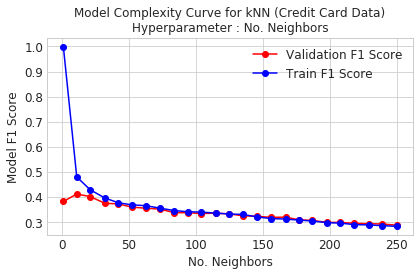

In [83]:
#Find model performance vs k
hyperKNN(X_train, y_train, X_val, y_val,title="Model Complexity Curve for kNN (Credit Card Data)\nHyperparameter : No. Neighbors")

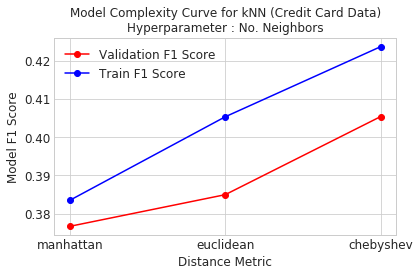

In [58]:
#Compare model performance for different distance metrics
hyperKNN2(X_train, y_train, X_val, y_val,title="Model Complexity Curve for kNN (Credit Card Data)\nHyperparameter : No. Neighbors")

Model Evaluation Metrics Using Train Dataset
*****************************************************
Model Training Time (s):   0.51985
F1 Score:  0.43
Accuracy:  0.81     AUC:       0.64
Precision: 0.68     Recall:    0.31
Model Evaluation Metrics Using Untouched Test Dataset
*****************************************************
Model Prediction Time (s): 6.36513

F1 Score:  0.40
Accuracy:  0.82     AUC:       0.62
Precision: 0.64     Recall:    0.29
*****************************************************


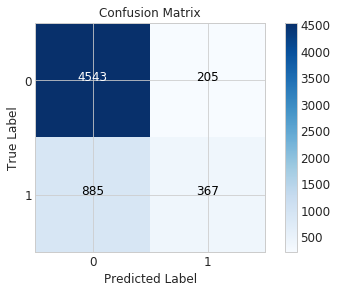

In [59]:
#Build Model and get evaluation statistics
estimator_cc = kNN(n_neighbors=33, metric = 'chebyshev',n_jobs=-1)
final_classifier_evaluation(estimator_cc, X_train_val_scaled, X_test_scaled, y_train_val, y_test)

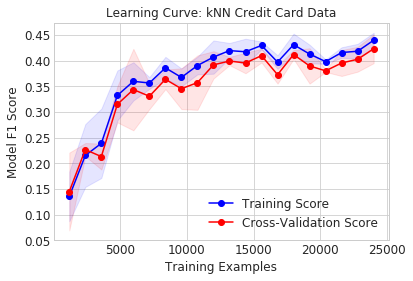

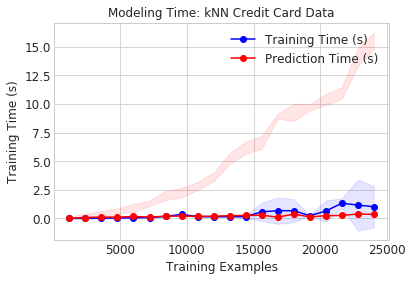

In [68]:
#Plot Learning Curve
train_samp_cc, kNN_train_score_cc, kNN_fit_time_cc, kNN_pred_time_cc = plot_learning_curve(estimator_cc, X_train_val_scaled, y_train_val,title="kNN Credit Card Data")

In [69]:
#Break Bank Marketing Data into train, validation and test

X_train_val, X_test, y_train_val, y_test = train_test_split(np.array(bankX),np.array(bankY), test_size=0.20, random_state = 33)
scaler = StandardScaler().fit(X_train_val)
X_train_val_scaled = scaler.transform(X_train_val)
X_test_scaled = scaler.transform(X_test)
X_train, X_val, y_train, y_val = train_test_split(X_train_val_scaled,y_train_val, test_size=0.25, random_state = 33)

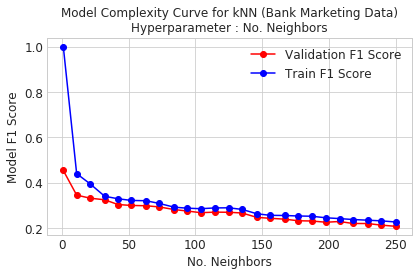

In [80]:
#Find optimal nearest neighbors
hyperKNN(X_train, y_train, X_val, y_val,title="Model Complexity Curve for kNN (Bank Marketing Data)\nHyperparameter : No. Neighbors")

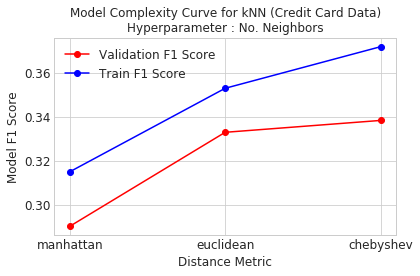

In [61]:
#Find best distance metric
hyperKNN2(X_train, y_train, X_val, y_val,title="Model Complexity Curve for kNN (Credit Card Data)\nHyperparameter : No. Neighbors")

Model Evaluation Metrics Using Train Dataset
*****************************************************
Model Training Time (s):   6.50791
F1 Score:  0.37
Accuracy:  0.90     AUC:       0.62
Precision: 0.65     Recall:    0.26
Model Evaluation Metrics Using Untouched Test Dataset
*****************************************************
Model Prediction Time (s): 18.23783

F1 Score:  0.33
Accuracy:  0.90     AUC:       0.61
Precision: 0.62     Recall:    0.23
*****************************************************


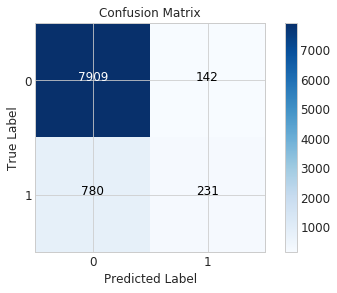

In [64]:
#Build model and get evaluation statistics
estimator_bank = kNN(n_neighbors=33, metric = 'chebyshev',n_jobs=-1)
final_classifier_evaluation(estimator_bank, X_train_val_scaled, X_test_scaled, y_train_val, y_test)

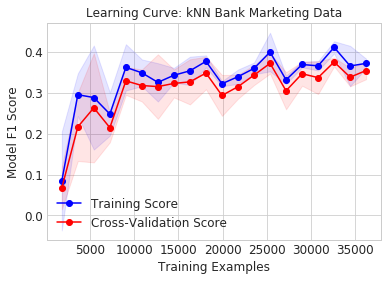

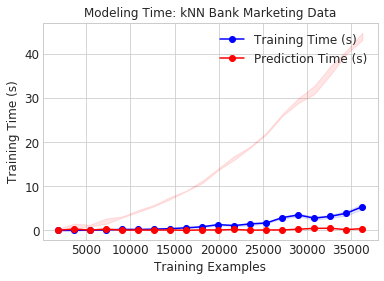

In [70]:
#Plot learning curve
train_samp_bank, kNN_train_score_bank, kNN_fit_time_bank, kNN_pred_time_bank = plot_learning_curve(estimator_bank, X_train_val_scaled, y_train_val,title="kNN Bank Marketing Data")

# Decision Tree Classifier

This section will build a Decision Tree Classifier using information gain (based on entropy) to determine the best feature split per the ID3 algorithm. The model will be pre-pruned by limiting tree depth using the hyperparameter 'max_depth' and by ensuring that each leaf (a terminal node on the tree) has at least 'min_samples_leaf'. 

In [105]:
from sklearn.tree import DecisionTreeClassifier

def hyperTree(X_train, y_train, X_test, y_test, title):
    
    f1_test = []
    f1_train = []
    max_depth = list(range(1,31))
    for i in max_depth:         
            clf = DecisionTreeClassifier(max_depth=i, random_state=100, min_samples_leaf=1, criterion='entropy')
            clf.fit(X_train, y_train)
            y_pred_test = clf.predict(X_test)
            y_pred_train = clf.predict(X_train)
            f1_test.append(f1_score(y_test, y_pred_test))
            f1_train.append(f1_score(y_train, y_pred_train))
      
    plt.plot(max_depth, f1_test, 'o-', color='r', label='Validation F1 Score')
    plt.plot(max_depth, f1_train, 'o-', color = 'b', label='Train F1 Score')
    plt.ylabel('Model F1 Score')
    plt.xlabel('Max Tree Depth')
    
    plt.title(title)
    plt.legend(loc='best')
    plt.tight_layout()
    plt.show()
     
    
def TreeGridSearchCV(X_train, y_train):
    #parameters to search:
    #20 values of min_samples leaf from 0.5% sample to 5% of the training data
    #20 values of max_depth from 1, 20
    param_grid = {'min_samples_leaf':np.linspace(0.01, 0.1, 5, endpoint=True),
                  'min_samples_split': np.linspace(1e-5, 1e-3, 10, endpoint=True),
                  'max_features': ['sqrt','log2',None],
                  'max_depth':np.arange(1,10)}

    tree = GridSearchCV(estimator = DecisionTreeClassifier(criterion = 'entropy'), param_grid=param_grid, cv=3, scoring = 'f1')
    tree.fit(X_train, y_train)
    print("Per Hyperparameter tuning, best parameters are:")
    print(tree.best_params_)
    return tree.best_params_['min_samples_leaf'],tree.best_params_['min_samples_split'],tree.best_params_['max_features'], tree.best_params_['max_depth']

In [106]:
#Break Credit Card Data into train, validation and test

ccX,ccY,bankX,bankY = import_data()
X_train_val, X_test, y_train_val, y_test = train_test_split(np.array(ccX),np.array(ccY), test_size=0.20, random_state = 3)
scaler = StandardScaler().fit(X_train_val)
X_train_val_scaled = scaler.transform(X_train_val)
X_test_scaled = scaler.transform(X_test)
X_train, X_val, y_train, y_val = train_test_split(X_train_val_scaled,y_train_val, test_size=0.25, random_state = 3)

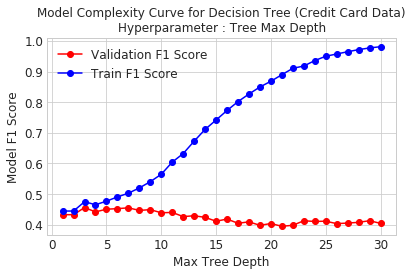

In [133]:
#Find optimal tree depth
hyperTree(X_train, y_train, X_val, y_val,title="Model Complexity Curve for Decision Tree (Credit Card Data)\nHyperparameter : Tree Max Depth")

In [230]:
#Grid search to find optimal set of parameters
min_samples_leaf,min_samples_split,max_features, max_depth = TreeGridSearchCV(X_train_val_scaled,y_train_val)

Per Hyperparameter tuning, best parameters are:
{'max_features': None, 'min_samples_split': 1e-05, 'max_depth': 4, 'min_samples_leaf': 0.01}


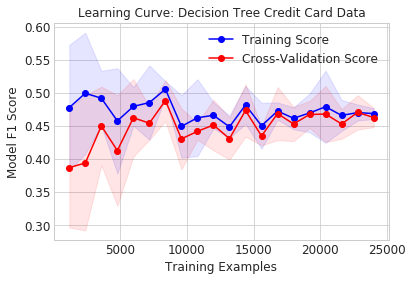

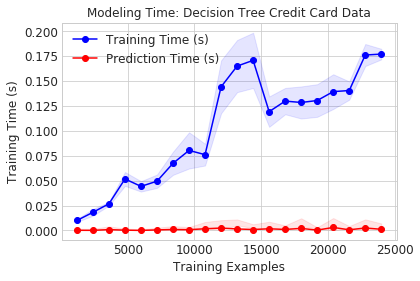

In [32]:
#Plot Learning Curve
estimator_cc = DecisionTreeClassifier(max_features = None, min_samples_split = 1e-5, max_depth=4, min_samples_leaf=0.01, random_state=100, criterion='entropy')
train_samp_cc, DT_train_score_cc, DT_fit_time_cc, DT_pred_time_cc = plot_learning_curve(estimator_cc, X_train_val_scaled, y_train_val,title="Decision Tree Credit Card Data")

Model Evaluation Metrics Using Train Dataset
*****************************************************
Model Training Time (s):   0.23478
F1 Score:  0.46
Accuracy:  0.82     AUC:       0.65
Precision: 0.68     Recall:    0.35
Model Evaluation Metrics Using Untouched Test Dataset
*****************************************************
Model Prediction Time (s): 0.00069

F1 Score:  0.48
Accuracy:  0.83     AUC:       0.66
Precision: 0.69     Recall:    0.37
*****************************************************


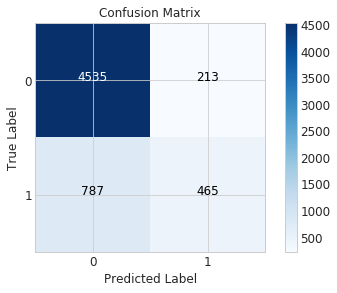

In [33]:
#Get Model Evaluation Statistics
final_classifier_evaluation(estimator_cc, X_train_val_scaled, X_test_scaled, y_train_val, y_test)

In [108]:
#Break Bank Marketing Data into train, validation and test
X_train_val, X_test, y_train_val, y_test = train_test_split(np.array(bankX),np.array(bankY), test_size=0.20, random_state = 33)
scaler = StandardScaler().fit(X_train_val)
X_train_val_scaled = scaler.transform(X_train_val)
X_test_scaled = scaler.transform(X_test)
X_train, X_val, y_train, y_val = train_test_split(X_train_val_scaled,y_train_val, test_size=0.25, random_state = 33)

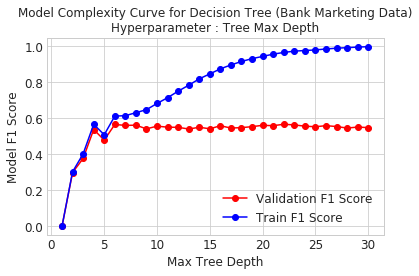

In [99]:
#Find optimal tree depth
hyperTree(X_train, y_train, X_val, y_val,title="Model Complexity Curve for Decision Tree (Bank Marketing Data)\nHyperparameter : Tree Max Depth")

In [151]:
#Grid search to find optimal set of hyperparameters
min_samples_leaf,min_samples_split,max_features, max_depth = TreeGridSearchCV(X_train_val_scaled,y_train_val)

Per Hyperparameter tuning, best parameters are:
{'max_features': None, 'min_samples_split': 1e-05, 'max_depth': 6, 'min_samples_leaf': 0.0055000000000000005}


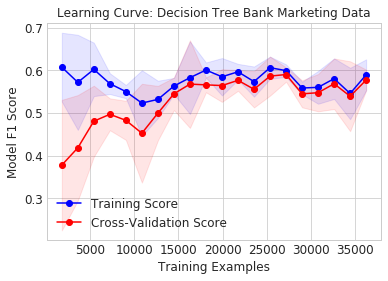

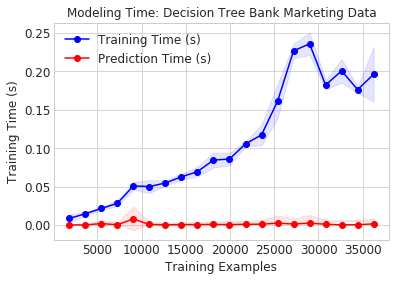

In [36]:
#Plot learning curves
estimator_bank = DecisionTreeClassifier(max_features = max_features, min_samples_split = min_samples_split, max_depth=max_depth, min_samples_leaf=min_samples_leaf, random_state=100, criterion='entropy')
train_samp_bank, DT_train_score_bank, DT_fit_time_bank, DT_pred_time_bank = plot_learning_curve(estimator_bank, X_train_val_scaled, y_train_val,title="Decision Tree Bank Marketing Data")

Model Evaluation Metrics Using Train Dataset
*****************************************************
Model Training Time (s):   0.24922
F1 Score:  0.59
Accuracy:  0.91     AUC:       0.75
Precision: 0.64     Recall:    0.55
Model Evaluation Metrics Using Untouched Test Dataset
*****************************************************
Model Prediction Time (s): 0.00131

F1 Score:  0.58
Accuracy:  0.91     AUC:       0.75
Precision: 0.63     Recall:    0.54
*****************************************************


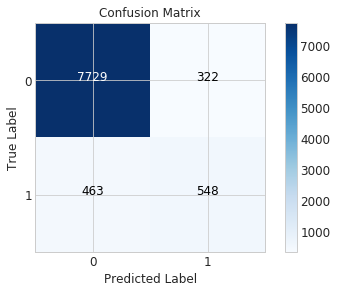

In [37]:
#Get model evaluation statistics
final_classifier_evaluation(estimator_bank, X_train_val_scaled, X_test_scaled, y_train_val, y_test)

# Boosted Decision Tree Classifier

This section will implement a boosted version of the earlier decision tree. We will still keep the pruning based on max_depth and min_samples_leaf, but the cutoff thresholds will be more aggressive (lower) since the power of boosting is to combine multiple weak learners. We also introduce the hyperparameter of n_estimators and learning rate which will determine the contribution of each tree classifier.

In [125]:
from sklearn.ensemble import GradientBoostingClassifier

def hyperBoost(X_train, y_train, X_test, y_test, max_depth, min_samples_leaf, title):
    
    f1_test = []
    f1_train = []
    n_estimators = np.linspace(1,250,40).astype('int')
    for i in n_estimators:         
            clf = GradientBoostingClassifier(n_estimators=i, max_depth=int(max_depth/2), 
                                             min_samples_leaf=int(min_samples_leaf/2), random_state=100)
            clf.fit(X_train, y_train)
            y_pred_test = clf.predict(X_test)
            y_pred_train = clf.predict(X_train)
            f1_test.append(f1_score(y_test, y_pred_test))
            f1_train.append(f1_score(y_train, y_pred_train))
      
    plt.plot(n_estimators, f1_test, 'o-', color='r', label='Validation F1 Score')
    plt.plot(n_estimators, f1_train, 'o-', color = 'b', label='Train F1 Score')
    plt.ylabel('Model F1 Score')
    plt.xlabel('No. Estimators')
    
    plt.title(title)
    plt.legend(loc='best')
    plt.tight_layout()
    plt.show()

def BoostedGridSearchCV(X_train, y_train):
    #parameters to search:
    #n_estimators, learning_rate, max_depth, min_samples_leaf
#     param_grid = {'min_samples_leaf': np.linspace(start_leaf_n,end_leaf_n,3).round().astype('int'),
#                   'max_depth': np.arange(1,4),
#                   'n_estimators': np.linspace(10,100,3).round().astype('int'),
#                   'learning_rate': np.linspace(.001,.1,3)}
    
#     param_grid = {'min_samples_leaf': np.linspace(0.01, 0.1, 5, endpoint=True),
#               'max_depth': np.arange(1,10,2),
#               'learning_rate': [0.001,0.01,0.1],
#               'min_samples_split': np.linspace(1e-5, 1e-3, 5, endpoint=True)}
    #param_grid = {'min_samples_split': [0.0007525], 'learning_rate': [0.1], 'max_depth': [5], 'min_samples_leaf': [0.05500000000000001]}
    param_grid = {'min_samples_split': [1e-3], 'learning_rate': [0.1], 'max_depth': [5], 'min_samples_leaf': [0.01]}

    boost = GridSearchCV(estimator = GradientBoostingClassifier(n_estimators = 100, random_state = 100), param_grid=param_grid, cv=3,scoring = 'f1')
    boost.fit(X_train, y_train)
    print("Per Hyperparameter tuning, best parameters are:")
    print(boost.best_params_)
    return boost.best_params_['max_depth'], boost.best_params_['min_samples_leaf'], boost.best_params_['learning_rate'], boost.best_params_['min_samples_split']

In [115]:
#Break Credit Card Data into train, validation and test

ccX,ccY,bankX,bankY = import_data()
X_train_val, X_test, y_train_val, y_test = train_test_split(np.array(ccX),np.array(ccY), test_size=0.20, random_state = 3)
scaler = StandardScaler().fit(X_train_val)
X_train_val_scaled = scaler.transform(X_train_val)
X_test_scaled = scaler.transform(X_test)
X_train, X_val, y_train, y_val = train_test_split(X_train_val_scaled,y_train_val, test_size=0.25, random_state = 3)

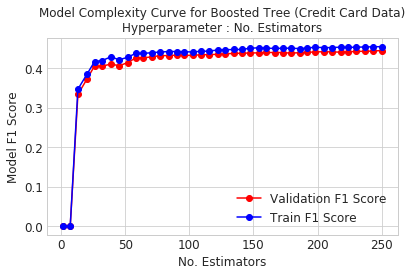

In [239]:
#Find optimal number of trees
hyperBoost(X_train, y_train, X_val, y_val, 3, 50, title="Model Complexity Curve for Boosted Tree (Credit Card Data)\nHyperparameter : No. Estimators")

In [124]:
#Grid Search to find optimal set of hyperparameters
max_depth, min_samples_leaf, learn_rate, min_samples_split = BoostedGridSearchCV(X_train_val_scaled,y_train_val)

Per Hyperparameter tuning, best parameters are:
{'min_samples_split': 0.0007525, 'learning_rate': 0.1, 'max_depth': 5, 'min_samples_leaf': 0.05500000000000001}


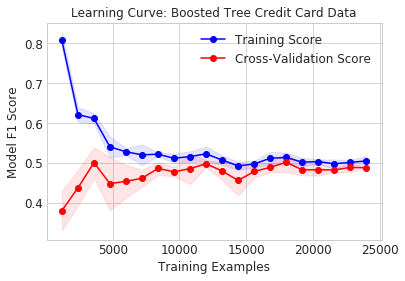

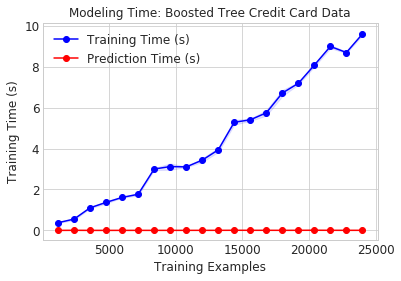

In [46]:
#Plot Learning Curve
estimator_cc = GradientBoostingClassifier(max_depth=5, min_samples_split = 0.0007525, min_samples_leaf=0.055, 
                                        learning_rate=0.1, n_estimators = 100, random_state = 100)
train_samp_cc, BT_train_score_cc, BT_fit_time_cc, BT_pred_time_cc = plot_learning_curve(estimator_cc, X_train_val_scaled, y_train_val,title="Boosted Tree Credit Card Data")

Model Evaluation Metrics Using Train Dataset
*****************************************************
Model Training Time (s):   13.59756
F1 Score:  0.49
Accuracy:  0.82     AUC:       0.66
Precision: 0.67     Recall:    0.38
Model Evaluation Metrics Using Untouched Test Dataset
*****************************************************
Model Prediction Time (s): 0.04580

F1 Score:  0.50
Accuracy:  0.83     AUC:       0.67
Precision: 0.67     Recall:    0.39
*****************************************************


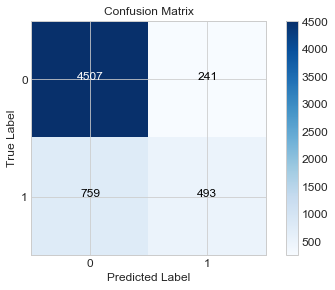

In [66]:
#Get Model Evaluation Statistics
final_classifier_evaluation(estimator_cc, X_train_val_scaled, X_test_scaled, y_train_val, y_test)

In [126]:
#Break Bank Marketing Data in train, validation and test
X_train_val, X_test, y_train_val, y_test = train_test_split(np.array(bankX),np.array(bankY), test_size=0.20, random_state = 33)
scaler = StandardScaler().fit(X_train_val)
X_train_val_scaled = scaler.transform(X_train_val)
X_test_scaled = scaler.transform(X_test)
X_train, X_val, y_train, y_val = train_test_split(X_train_val_scaled,y_train_val, test_size=0.25, random_state = 33)

/home/ravi/miniconda2/lib/python2.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


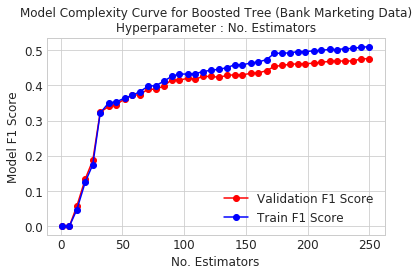

In [14]:
#Search for optimal number of trees
hyperBoost(X_train, y_train, X_val, y_val, 3, 50, title="Model Complexity Curve for Boosted Tree (Bank Marketing Data)\nHyperparameter : No. Estimators")

In [127]:
#Grid Search to find optimal set of hyperparameters
max_depth, min_samples_leaf, learn_rate, min_samples_split = BoostedGridSearchCV(X_train_val_scaled,y_train_val)

Per Hyperparameter tuning, best parameters are:
{'min_samples_split': 0.001, 'learning_rate': 0.1, 'max_depth': 5, 'min_samples_leaf': 0.01}


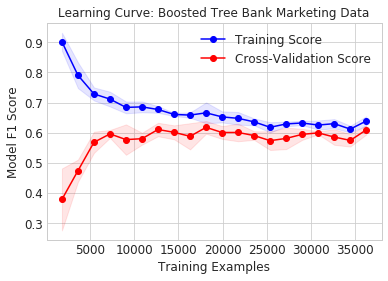

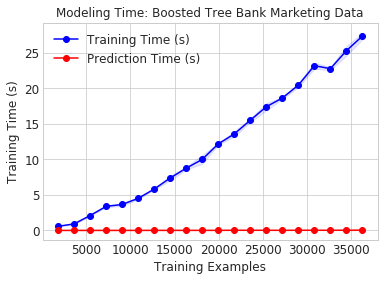

In [49]:
#Plot learning curves
estimator_bank = GradientBoostingClassifier(max_depth=5,min_samples_leaf=0.01, min_samples_split = 1e-3, learning_rate = 0.1,n_estimators = 80,random_state=400)
train_samp_bank, BT_train_score_bank, BT_fit_time_bank, BT_pred_time_bank = plot_learning_curve(estimator_bank, X_train_val_scaled, y_train_val,title="Boosted Tree Bank Marketing Data")

Model Evaluation Metrics Using Train Dataset
*****************************************************
Model Training Time (s):   32.37411
F1 Score:  0.60
Accuracy:  0.92     AUC:       0.76
Precision: 0.68     Recall:    0.55
Model Evaluation Metrics Using Untouched Test Dataset
*****************************************************
Model Prediction Time (s): 0.03469

F1 Score:  0.59
Accuracy:  0.92     AUC:       0.75
Precision: 0.66     Recall:    0.53
*****************************************************


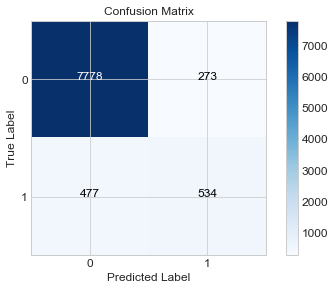

In [70]:
#Get model evaluation statistics
final_classifier_evaluation(estimator_bank, X_train_val_scaled, X_test_scaled, y_train_val, y_test)

# 4. Model Comparison Plots

Finally, let's define and call a function that will plot training times and learning rates for the 5 different algorithms so that we can compare across the classifiers for the same dataset.

In [119]:
def compare_fit_time(n,NNtime, SMVtime, kNNtime, DTtime, BTtime, title):
    
    plt.figure()
    plt.title("Model Training Times: " + title)
    plt.xlabel("Training Examples")
    plt.ylabel("Model Training Time (s)")
    plt.plot(n, NNtime, '-', color="b", label="Neural Network")
    plt.plot(n, SMVtime, '-', color="r", label="SVM")
    plt.plot(n, kNNtime, '-', color="g", label="kNN")
    plt.plot(n, DTtime, '-', color="m", label="Decision Tree")
    plt.plot(n, BTtime, '-', color="k", label="Boosted Tree")
    plt.legend(loc="best")
    plt.show()
    
def compare_pred_time(n,NNpred, SMVpred, kNNpred, DTpred, BTpred, title):
    
    plt.figure()
    plt.title("Model Prediction Times: " + title)
    plt.xlabel("Training Examples")
    plt.ylabel("Model Prediction Time (s)")
    plt.plot(n, NNpred, '-', color="b", label="Neural Network")
    plt.plot(n, SMVpred, '-', color="r", label="SVM")
    plt.plot(n, kNNpred, '-', color="g", label="kNN")
    plt.plot(n, DTpred, '-', color="m", label="Decision Tree")
    plt.plot(n, BTpred, '-', color="k", label="Boosted Tree")
    plt.legend(loc="best")
    plt.show()


def compare_learn_time(n,NNlearn, SMVlearn, kNNlearn, DTlearn, BTlearn, title):
    
    plt.figure()
    plt.title("Model Learning Rates: " + title)
    plt.xlabel("Training Examples")
    plt.ylabel("Model F1 Score")
    plt.plot(n, NNlearn, '-', color="b", label="Neural Network")
    plt.plot(n, SMVlearn, '-', color="r", label="SVM")
    plt.plot(n, kNNlearn, '-', color="g", label="kNN")
    plt.plot(n, DTlearn, '-', color="m", label="Decision Tree")
    plt.plot(n, BTlearn, '-', color="k", label="Boosted Tree")
    plt.legend(loc="best")
    plt.show() 

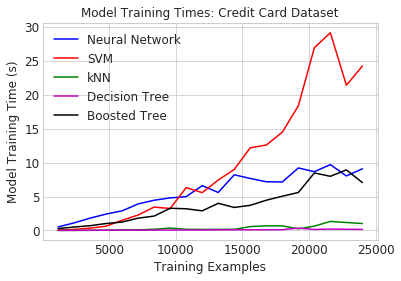

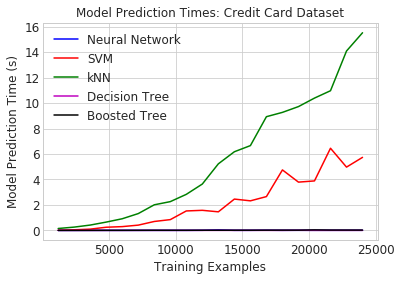

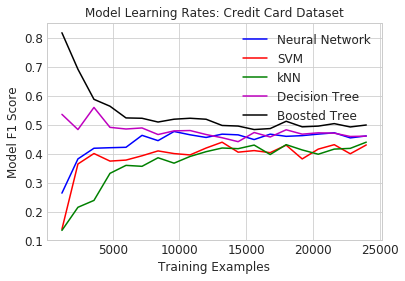

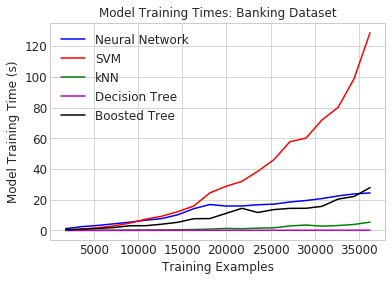

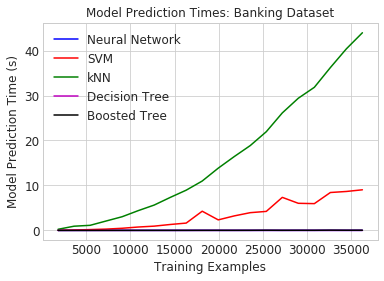

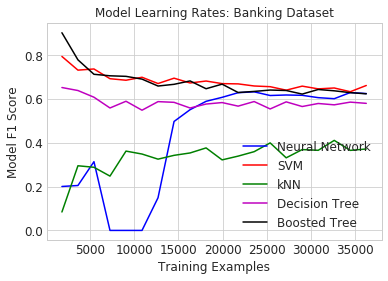

In [120]:
compare_fit_time(train_samp_cc, NN_fit_time_cc, SVM_fit_time_cc, kNN_fit_time_cc, 
                 DT_fit_time_cc, BT_fit_time_cc, 'Credit Card Dataset')              
compare_pred_time(train_samp_cc, NN_pred_time_cc, SVM_pred_time_cc, kNN_pred_time_cc, 
                 DT_pred_time_cc, BT_pred_time_cc, 'Credit Card Dataset')   
compare_learn_time(train_samp_cc, NN_train_score_cc, SVM_train_score_cc, kNN_train_score_cc, 
                 DT_train_score_cc, BT_train_score_cc, 'Credit Card Dataset')  



compare_fit_time(train_samp_bank, NN_fit_time_bank, SVM_fit_time_bank, kNN_fit_time_bank, 
                 DT_fit_time_bank, BT_fit_time_bank, 'Banking Dataset')       
compare_pred_time(train_samp_bank, NN_pred_time_bank, SVM_pred_time_bank, kNN_pred_time_bank, 
                 DT_pred_time_bank, BT_pred_time_bank, 'Banking Dataset')           
compare_learn_time(train_samp_bank, NN_train_score_bank, SVM_train_score_bank, kNN_train_score_bank, 
                 DT_train_score_bank, BT_train_score_bank, 'Banking Dataset')